In [3]:
import os
current_dir = os.getcwd()
current_dir

'/Users/jacobambat/dev/Diabetes_DA_project/jupyter_notebooks'

In [4]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [5]:
current_dir = os.getcwd()
current_dir

'/Users/jacobambat/dev/Diabetes_DA_project'

In [1]:
DestinationFolder = "dataset/cleaned"

In [34]:
# Importing the Pandas library
import pandas as pd

# Loading the dataset
df = pd.read_csv(f'{DestinationFolder}/datacleanup2.csv')
df_original =pd.read_csv(f'{DestinationFolder}/datacleanup1.csv')

# Displaying the first few rows of the dataset
df.head()
df_original.head()

,Unnamed: 0,index,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,92509,Female,61.0,1,1,ever,32.36,5.8,130,0
1,1,99094,Male,44.0,0,0,not current,30.49,3.5,130,0
2,2,78961,Male,23.0,0,0,never,34.55,6.1,90,0
3,3,13302,Male,68.0,1,1,current,27.32,8.8,155,1
4,4,67956,Female,24.0,0,0,former,21.63,6.1,126,0


In [7]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history',
       'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes', 'AGE'],
      dtype='object')

In [9]:
df.dtypes

gender                  object
age                    float64
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
AGE                      int64
dtype: object

In [10]:
#convert object datatype to category
for col in df.select_dtypes('object'):
    df[col] = df[col].astype('category')
    print(df[col])


0       Female
1         Male
2         Male
3         Male
4       Female
         ...  
9806      Male
9807    Female
9808      Male
9809      Male
9810      Male
Name: gender, Length: 9811, dtype: category
Categories (3, object): ['Female', 'Male', 'Other']
0              ever
1       not current
2             never
3           current
4            former
           ...     
9806          never
9807          never
9808        No Info
9809        No Info
9810          never
Name: smoking_history, Length: 9811, dtype: category
Categories (6, object): ['No Info', 'current', 'ever', 'former', 'never', 'not current']


In [11]:
df.dtypes

gender                 category
age                     float64
hypertension              int64
heart_disease             int64
smoking_history        category
bmi                     float64
HbA1c_level             float64
blood_glucose_level       int64
diabetes                  int64
AGE                       int64
dtype: object

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.pipeline import Pipeline

In [19]:
def DataCleaningEffect(df_original,df_cleaned,variables_applied_with_method):
  """
  This function compares the distribution of variables before and after data cleaning.

  Parameters:
  df_original (DataFrame): The original DataFrame before cleaning.
  df_cleaned (DataFrame): The DataFrame after cleaning.
  variables_applied_with_method (list): The list of variables that the cleaning method was applied to.
  """

  flag_count=1 # Counter to keep track of the plot number
  
  # Identify categorical variables in the original DataFrame
  categorical_variables = df_original.select_dtypes(exclude=['number']).columns 

  # Loop over the variables that the cleaning method was applied to
  for set_of_variables in [variables_applied_with_method]:
    print("\n=====================================================================================")
    print(f"* Distribution Effect Analysis After Data Cleaning Method in the following variables:")
    print(f"{set_of_variables} \n\n")
  
    # For each variable, plot its distribution before and after cleaning
    for var in set_of_variables:
      if var in categorical_variables:  # If the variable is categorical, use a barplot
        # Create DataFrames for the original and cleaned data
        df1 = pd.DataFrame({"Type":"Original","Value":df_original[var]})
        df2 = pd.DataFrame({"Type":"Cleaned","Value":df_cleaned[var]})
        # Concatenate the two DataFrames
        dfAux = pd.concat([df1, df2], axis=0)
        # Create the plot
        fig , axes = plt.subplots(figsize=(15, 5))
        sns.countplot(hue='Type', data=dfAux, x="Value",palette=['#432371',"#FAAE7B"])
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.xticks(rotation=90)
        plt.legend() 

      else: # If the variable is numerical, use a histogram
        # Create the plot
        fig , axes = plt.subplots(figsize=(10, 5))
        sns.histplot(data=df_original, x=var, color="#432371", label='Original', kde=True,element="step", ax=axes)
        sns.histplot(data=df_cleaned, x=var, color="#FAAE7B", label='Cleaned', kde=True,element="step", ax=axes)
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.legend()

In [12]:
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')

In [14]:
def FeatureEngineeringAnalysis(df,analysis_type=None):


  """
  - used for quick feature engineering on numerical and categorical variables
  to decide which transformation can better transform the distribution shape 
  - Once transformed, use a reporting tool, like pandas-profiling, to evaluate distributions

  """
  check_missing_values(df)
  allowed_types= ['numerical', 'ordinal_encoder',  'outlier_winsorizer']
  check_user_entry_on_analysis_type(analysis_type, allowed_types)
  list_column_transformers = define_list_column_transformers(analysis_type)
  
  
  # Loop over each variable and engineer the data according to the analysis type
  df_feat_eng = pd.DataFrame([])
  for column in df.columns:
    # create additional columns (column_method) to apply the methods
    df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
    for method in list_column_transformers:
      df_feat_eng[f"{column}_{method}"] = df[column]
      
    # Apply transformers in respectives column_transformers
    df_feat_eng, list_applied_transformers = apply_transformers(analysis_type, df_feat_eng, column)

    # For each variable, assess how the transformations perform
    transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng)

  return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
  ### Check analyis type
  if analysis_type == None:
    raise SystemExit(f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
  if analysis_type not in allowed_types:
      raise SystemExit(f"analysis_type argument should be one of these options: {allowed_types}")

def check_missing_values(df):
  if df.isna().sum().sum() != 0:
    raise SystemExit(
        f"There is missing values in your dataset. Please handle that before getting into feature engineering.")



def define_list_column_transformers(analysis_type):
  ### Set suffix colummns acording to analysis_type
  if analysis_type=='numerical':
    list_column_transformers = ["log_e","log_10","reciprocal", "power","box_cox","yeo_johnson"]
  
  elif analysis_type=='ordinal_encoder':
    list_column_transformers = ["ordinal_encoder"]

  elif analysis_type=='outlier_winsorizer':
    list_column_transformers = ['iqr']

  return list_column_transformers



def apply_transformers(analysis_type, df_feat_eng, column):


  for col in df_feat_eng.select_dtypes(include='category').columns:
    df_feat_eng[col] = df_feat_eng[col].astype('object')


  if analysis_type=='numerical':
    df_feat_eng,list_applied_transformers = FeatEngineering_Numerical(df_feat_eng,column)
  
  elif analysis_type=='outlier_winsorizer':
    df_feat_eng,list_applied_transformers = FeatEngineering_OutlierWinsorizer(df_feat_eng,column)

  elif analysis_type=='ordinal_encoder':
    df_feat_eng,list_applied_transformers = FeatEngineering_CategoricalEncoder(df_feat_eng,column)

  return df_feat_eng,list_applied_transformers



def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
  # For each variable, assess how the transformations perform
  print(f"* Variable Analyzed: {column}")
  print(f"* Applied transformation: {list_applied_transformers} \n")
  for col in [column] + list_applied_transformers:
    
    if analysis_type!='ordinal_encoder':
      DiagnosticPlots_Numerical(df_feat_eng, col)
    
    else:
      if col == column: 
        DiagnosticPlots_Categories(df_feat_eng, col)
      else:
        DiagnosticPlots_Numerical(df_feat_eng, col)

    print("\n")



def DiagnosticPlots_Categories(df_feat_eng, col):
  plt.figure(figsize=(20, 5))
  sns.countplot(data=df_feat_eng, x=col,palette=['#432371'],order = df_feat_eng[col].value_counts().index)
  plt.xticks(rotation=90) 
  plt.suptitle(f"{col}", fontsize=30,y=1.05)        
  plt.show();
  print("\n")



def DiagnosticPlots_Numerical(df, variable):
  fig, axes = plt.subplots(1, 3, figsize=(20, 6))
  sns.histplot(data=df, x=variable, kde=True,element="step",ax=axes[0]) 
  stats.probplot(df[variable], dist="norm", plot=axes[1])
  sns.boxplot(x=df[variable],ax=axes[2])
  
  axes[0].set_title('Histogram')
  axes[1].set_title('QQ Plot')
  axes[2].set_title('Boxplot')
  fig.suptitle(f"{variable}", fontsize=30,y=1.05)
  plt.show();


def FeatEngineering_CategoricalEncoder(df_feat_eng,column):
  list_methods_worked = []
  try:  
    encoder= OrdinalEncoder(encoding_method='arbitrary', variables = [f"{column}_ordinal_encoder"])
    df_feat_eng = encoder.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_ordinal_encoder")
  
  except: 
    df_feat_eng.drop([f"{column}_ordinal_encoder"],axis=1,inplace=True)
    
  return df_feat_eng,list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng,column):
  list_methods_worked = []

  ### Winsorizer iqr
  try: 
    disc=Winsorizer(
        capping_method='iqr', tail='both', fold=1.5, variables = [f"{column}_iqr"])
    df_feat_eng = disc.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_iqr")
  except: 
    df_feat_eng.drop([f"{column}_iqr"],axis=1,inplace=True)


  return df_feat_eng,list_methods_worked




def FeatEngineering_Numerical(df_feat_eng,column):

  list_methods_worked = []

  ### LogTransformer base e
  try: 
    lt = vt.LogTransformer(variables = [f"{column}_log_e"])
    df_feat_eng = lt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_log_e")
  except: 
    df_feat_eng.drop([f"{column}_log_e"],axis=1,inplace=True)

    ### LogTransformer base 10
  try: 
    lt = vt.LogTransformer(variables = [f"{column}_log_10"],base='10')
    df_feat_eng = lt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_log_10")
  except: 
    df_feat_eng.drop([f"{column}_log_10"],axis=1,inplace=True)

  ### ReciprocalTransformer
  try:
    rt = vt.ReciprocalTransformer(variables = [f"{column}_reciprocal"])
    df_feat_eng =  rt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_reciprocal")
  except:
    df_feat_eng.drop([f"{column}_reciprocal"],axis=1,inplace=True)

  ### PowerTransformer
  try:
    pt = vt.PowerTransformer(variables = [f"{column}_power"])
    df_feat_eng = pt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_power")
  except:
    df_feat_eng.drop([f"{column}_power"],axis=1,inplace=True)

  ### BoxCoxTransformer
  try:
    bct = vt.BoxCoxTransformer(variables = [f"{column}_box_cox"])
    df_feat_eng = bct.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_box_cox")
  except:
    df_feat_eng.drop([f"{column}_box_cox"],axis=1,inplace=True)


  ### YeoJohnsonTransformer
  try:
    yjt = vt.YeoJohnsonTransformer(variables = [f"{column}_yeo_johnson"])
    df_feat_eng = yjt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_yeo_johnson")
  except:
        df_feat_eng.drop([f"{column}_yeo_johnson"],axis=1,inplace=True)
    
  return df_feat_eng,list_methods_worked

In [15]:
# Numerical
from feature_engine.imputation import MeanMedianImputer

In [43]:
variables_method = ['blood_glucose_level']
variables_method

['blood_glucose_level']

In [44]:
imputer = MeanMedianImputer(imputation_method='median', variables=variables_method)
df_method = imputer.fit_transform(df_original)


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['blood_glucose_level'] 




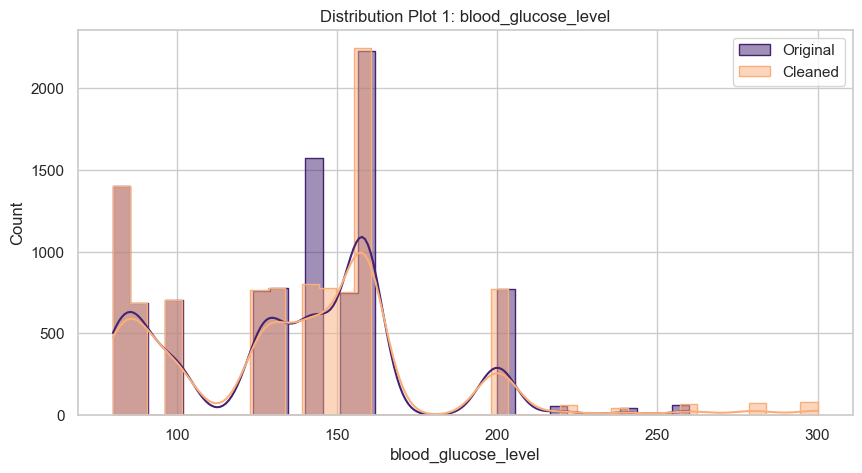

In [45]:
DataCleaningEffect(df_original=df,
                   df_cleaned=df_method,
                   variables_applied_with_method=variables_method)

In [21]:
#categorical
from feature_engine.imputation import CategoricalImputer

In [46]:
variables_method = ['gender', 'smoking_history']
variables_method

['gender', 'smoking_history']

In [47]:
imputer = CategoricalImputer(imputation_method='missing',fill_value='Missing',
                             variables=variables_method)

df_method = imputer.fit_transform(df_original)


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['gender', 'smoking_history'] 




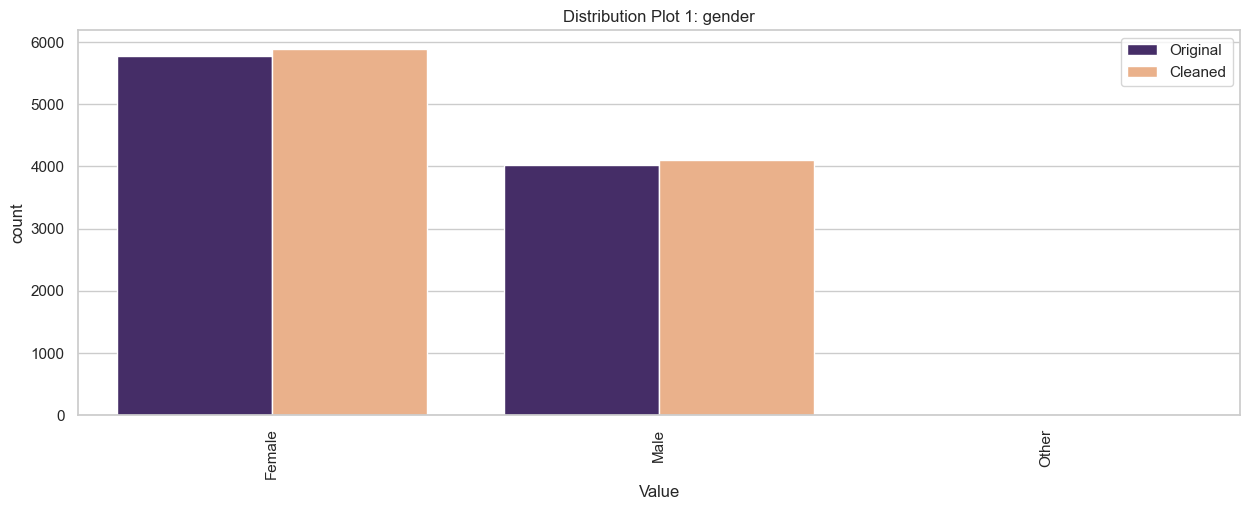

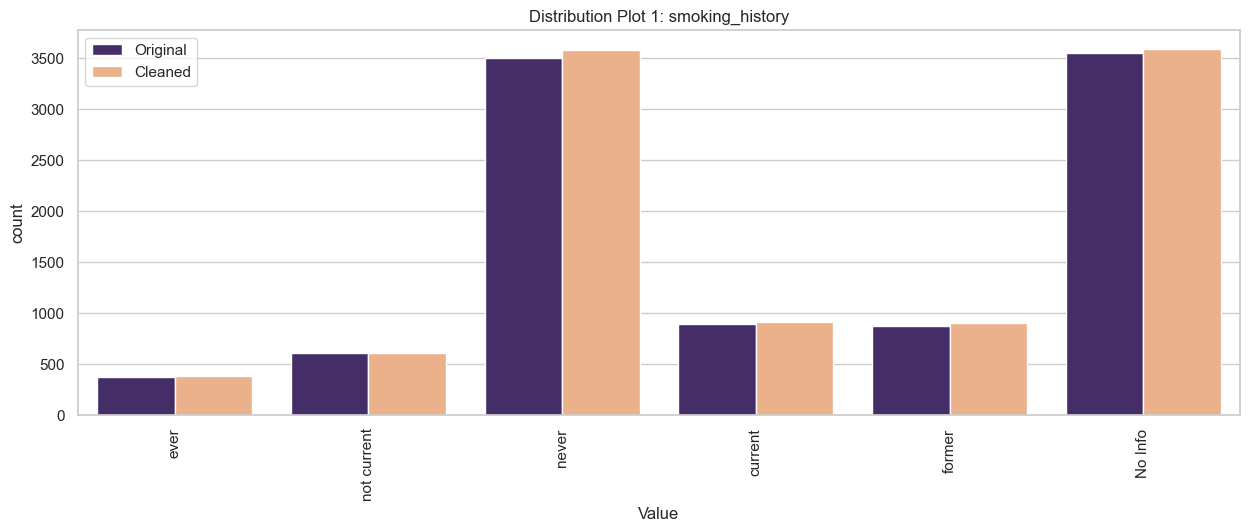

In [48]:
DataCleaningEffect(df_original=df,
                   df_cleaned=df_method,
                   variables_applied_with_method=variables_method)

In [71]:
df.dtypes

gender                  object
age                    float64
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
AGE                      int64
dtype: object

In [68]:
#ordinal encoder
variables_engineering= ['gender', 'smoking_history']
variables_engineering

['gender', 'smoking_history']

In [69]:
df_engineering = df[variables_engineering].copy()
df_engineering.head(3)

,gender,smoking_history
0,Female,ever
1,Male,not current
2,Male,never


* Variable Analyzed: gender
* Applied transformation: ['gender_ordinal_encoder'] 



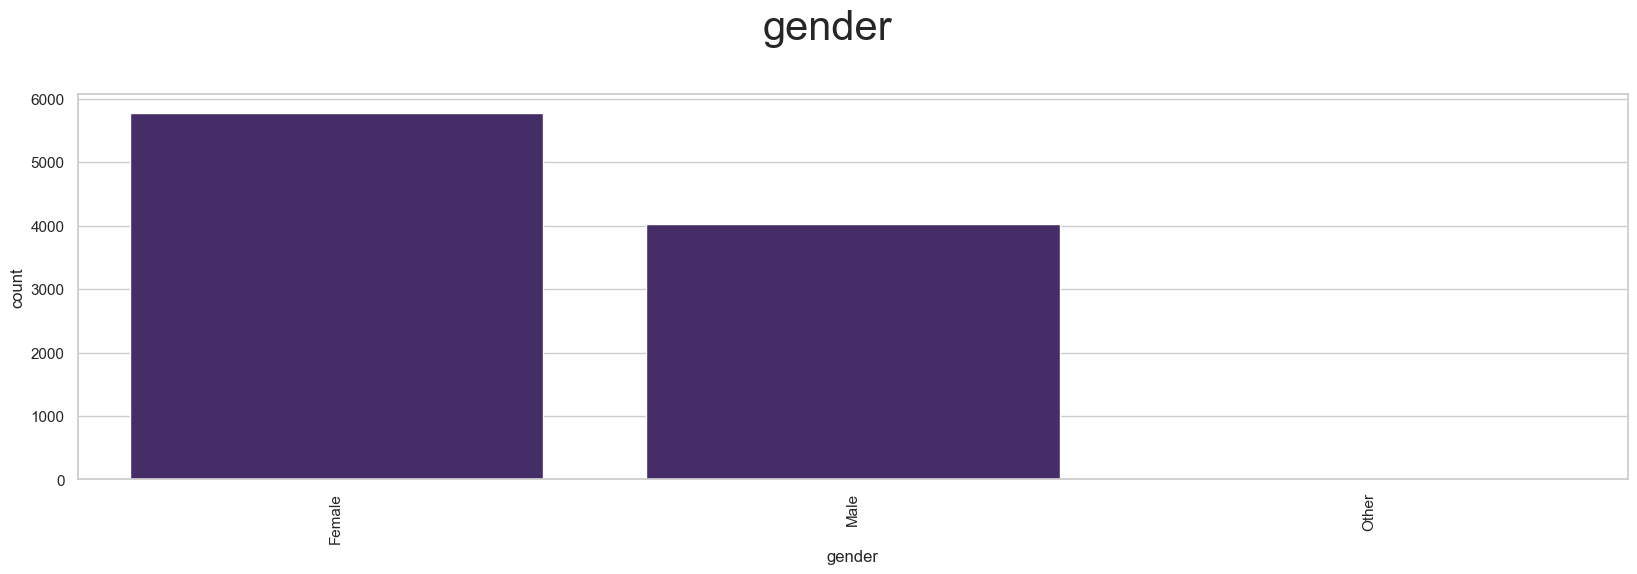

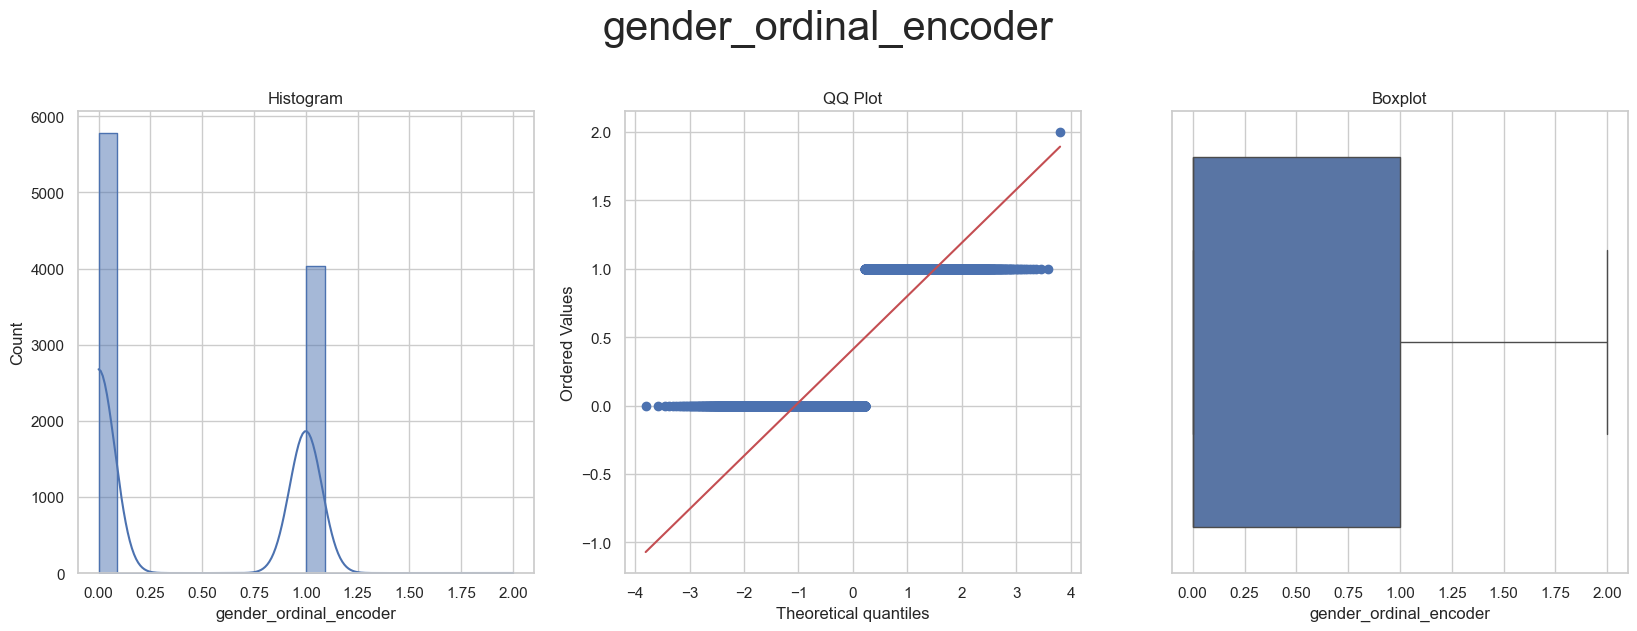



* Variable Analyzed: smoking_history
* Applied transformation: ['smoking_history_ordinal_encoder'] 



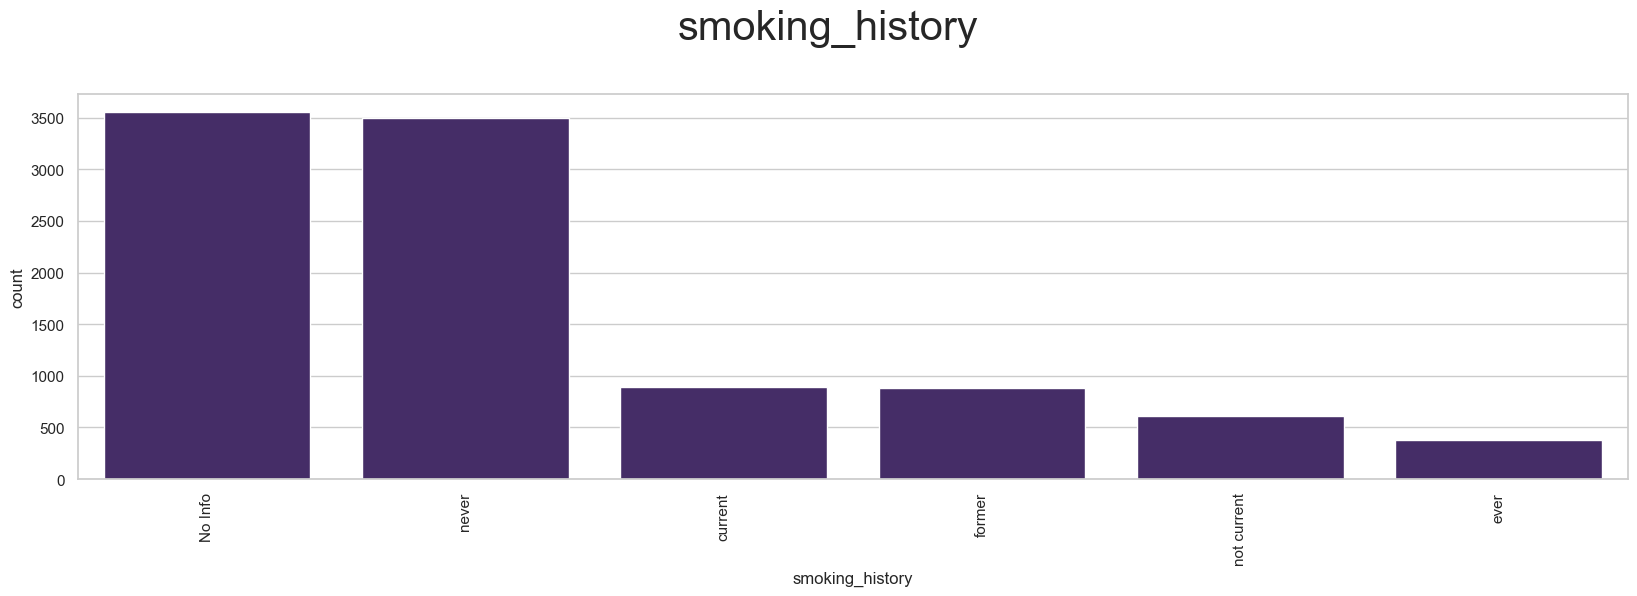

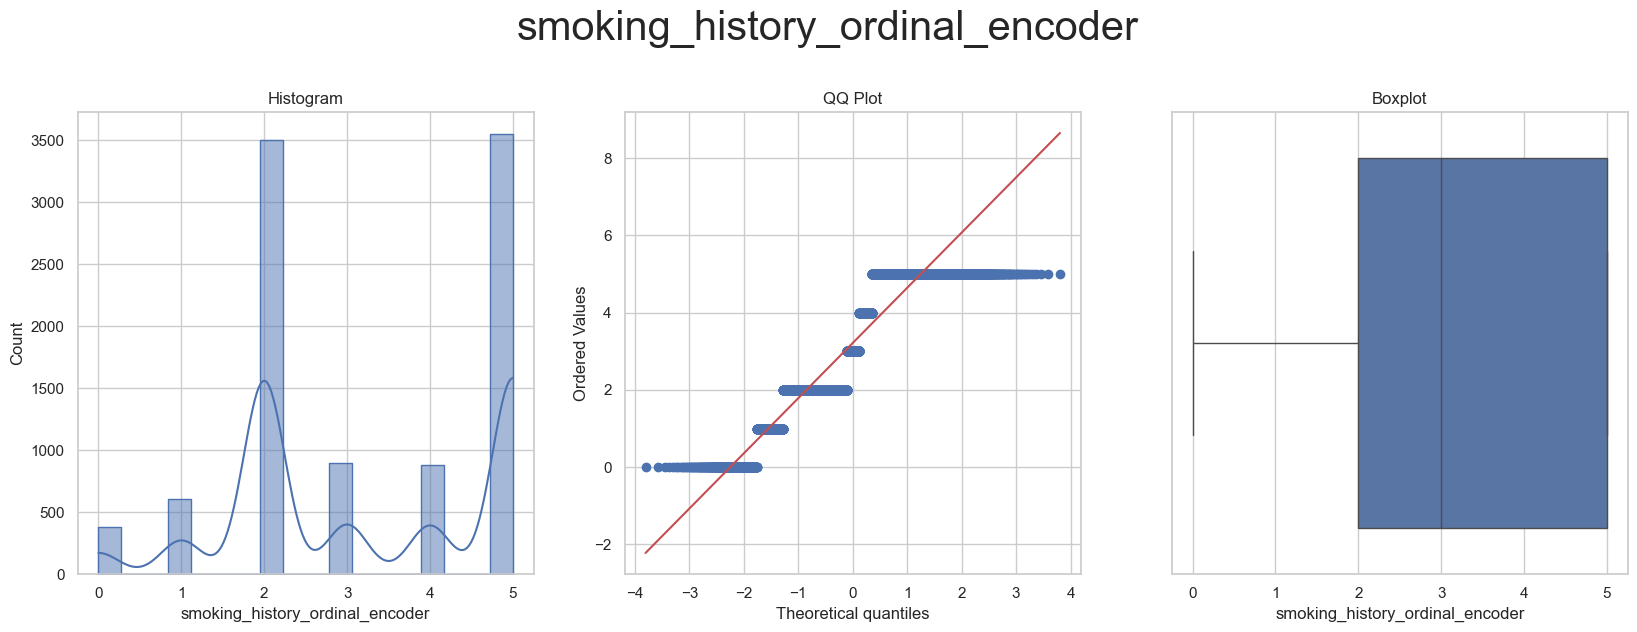

In [70]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering,analysis_type='ordinal_encoder')

In [57]:
#outlier
variables_engineering = ['bmi', 'blood_glucose_level']
variables_engineering

['bmi', 'blood_glucose_level']

In [62]:
df_engineering = df[variables_engineering].copy()
df_engineering.head(3)

,bmi,blood_glucose_level
0,32.36,130
1,30.49,130
2,34.55,90


* Variable Analyzed: bmi
* Applied transformation: ['bmi_iqr'] 



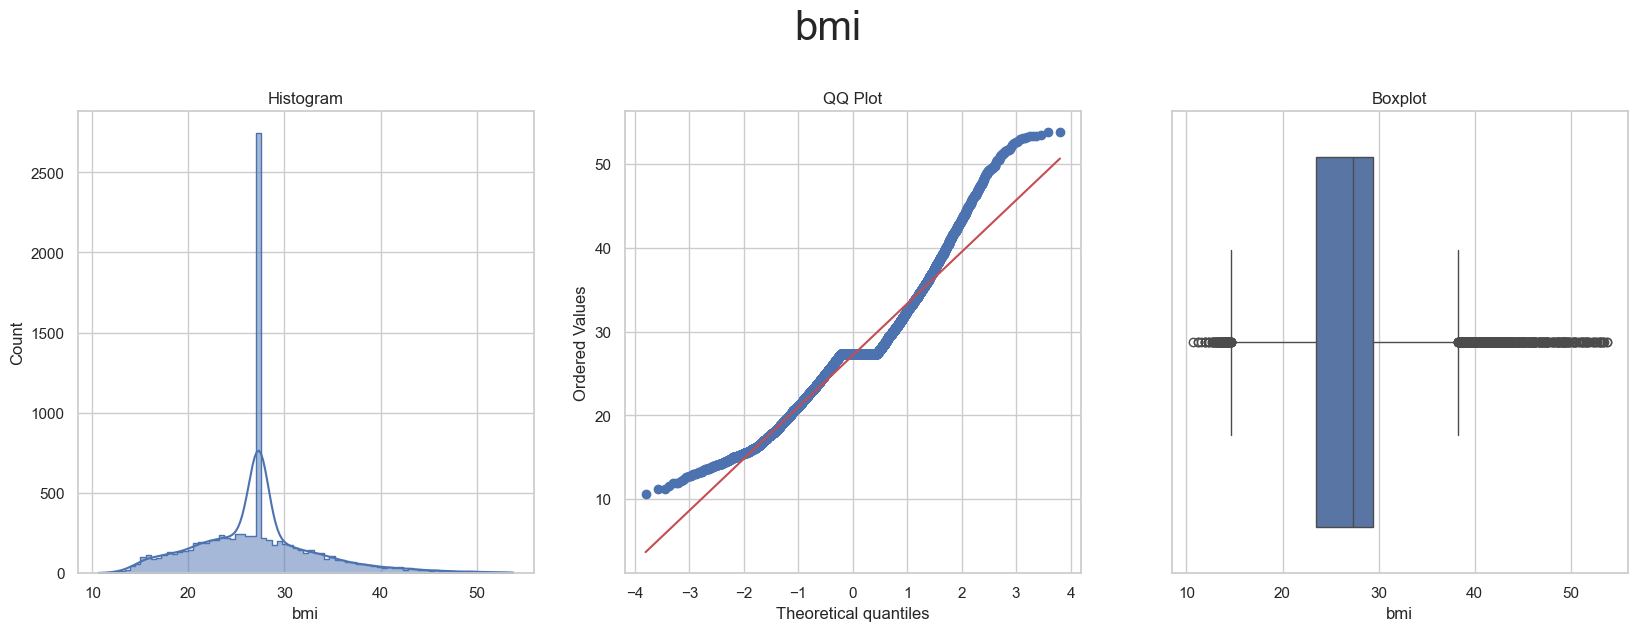

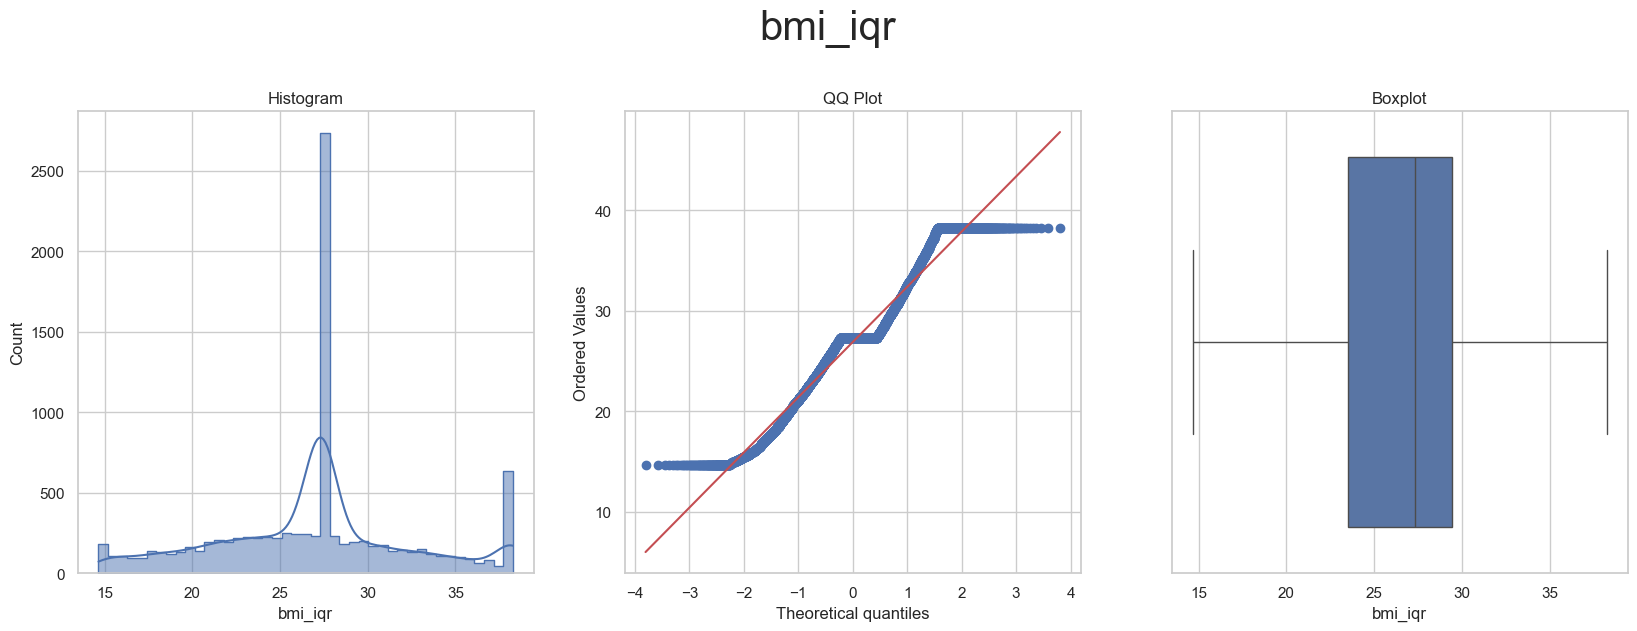



* Variable Analyzed: blood_glucose_level
* Applied transformation: ['blood_glucose_level_iqr'] 



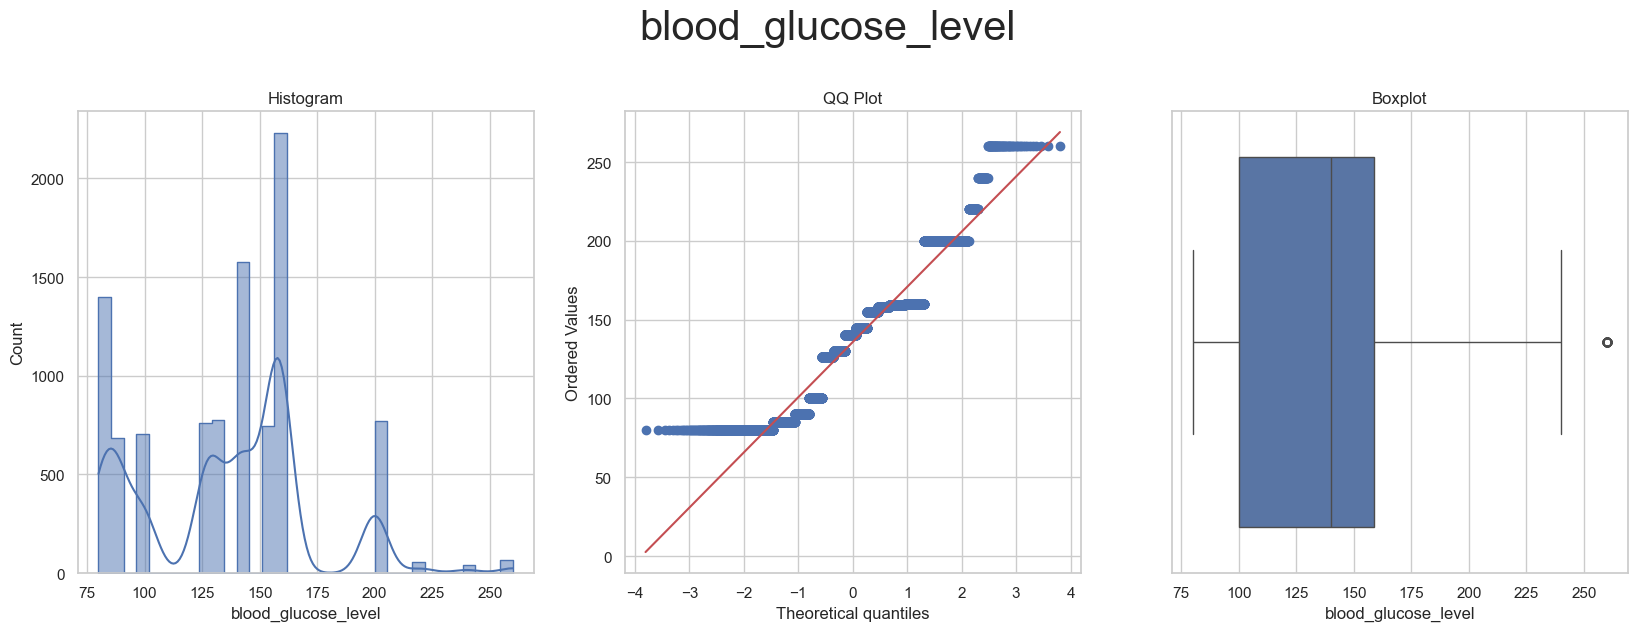

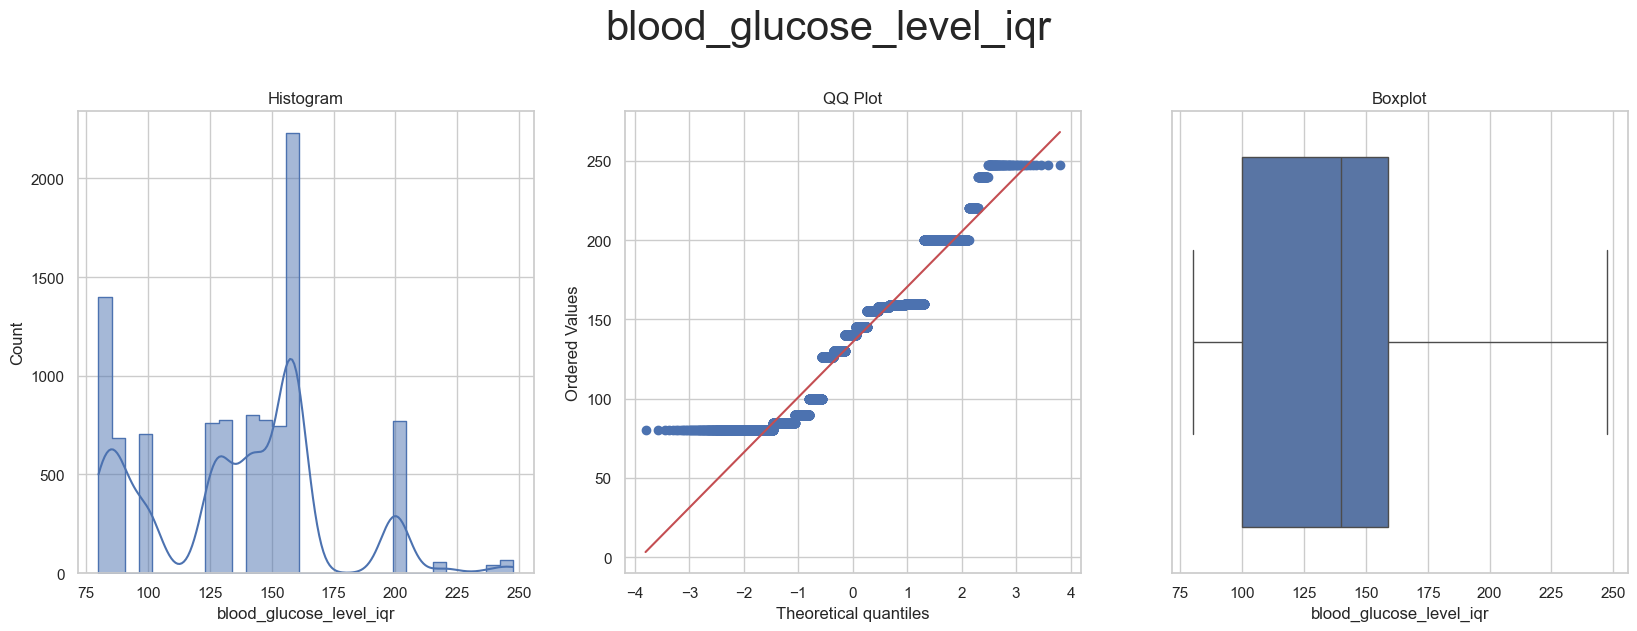

In [63]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering.dropna(),
                                            analysis_type='outlier_winsorizer')

In [73]:
#Numerical
variables_engineering= ['bmi']
variables_engineering

['bmi']

In [74]:
df_engineering = df[variables_engineering].copy()
df_engineering.head(3)

,bmi
0,32.36
1,30.49
2,34.55


In [75]:
df_engineering = df[variables_engineering].copy()
df_engineering.head(3)

,bmi
0,32.36
1,30.49
2,34.55


* Variable Analyzed: bmi
* Applied transformation: ['bmi_log_e', 'bmi_log_10', 'bmi_reciprocal', 'bmi_power', 'bmi_box_cox', 'bmi_yeo_johnson'] 



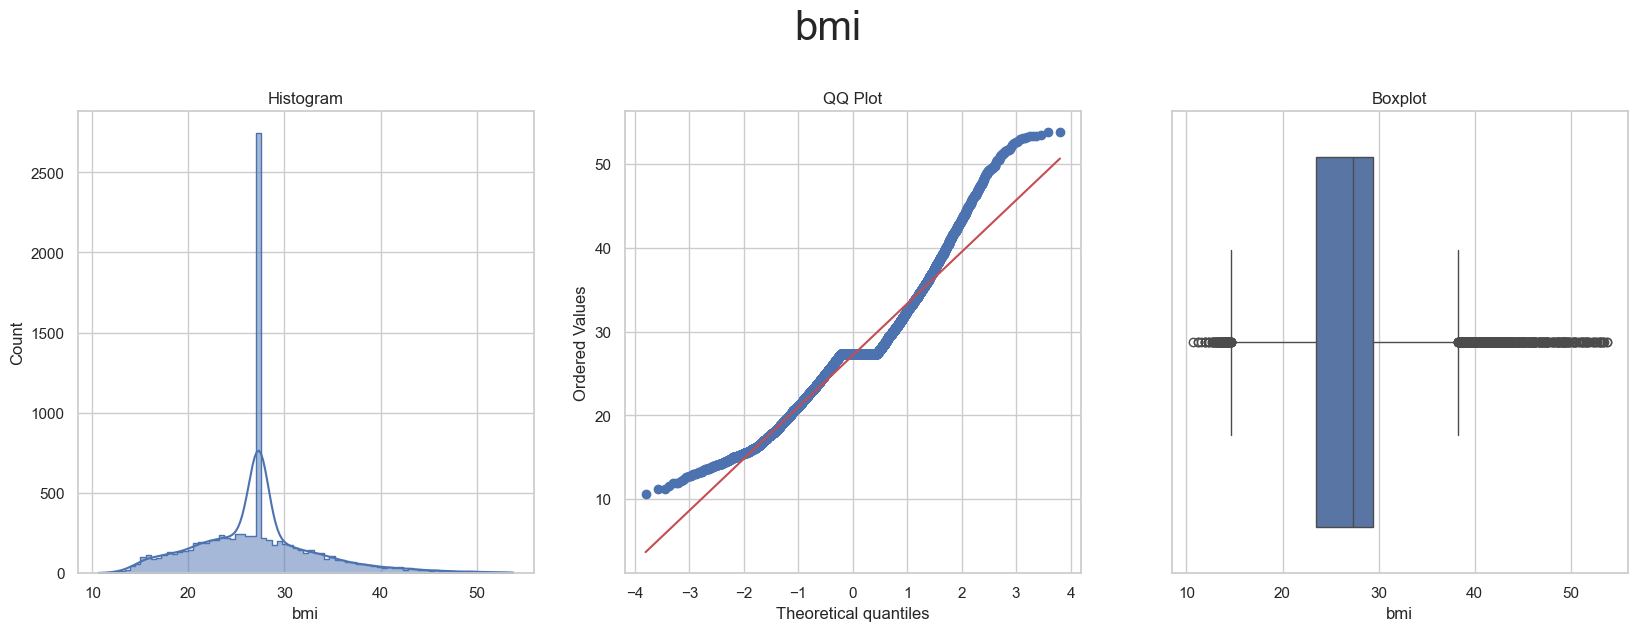

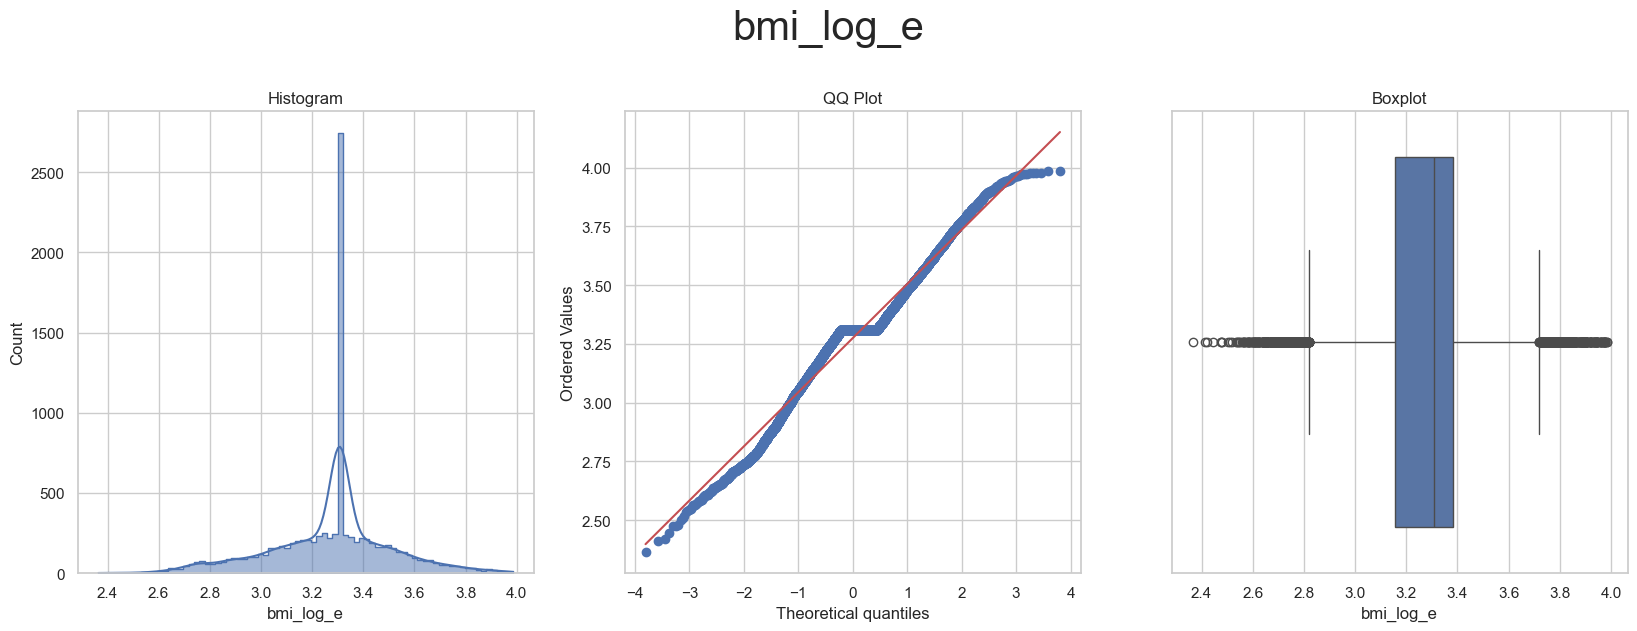

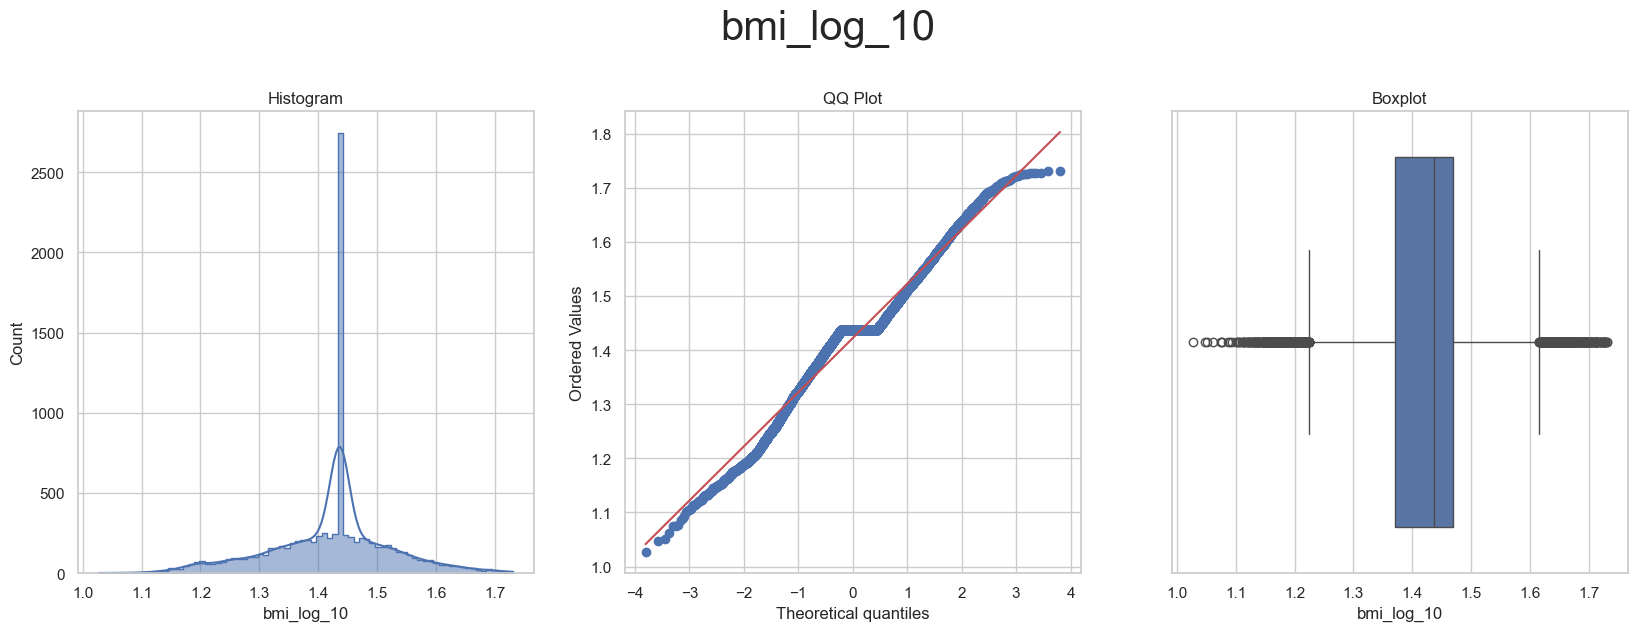

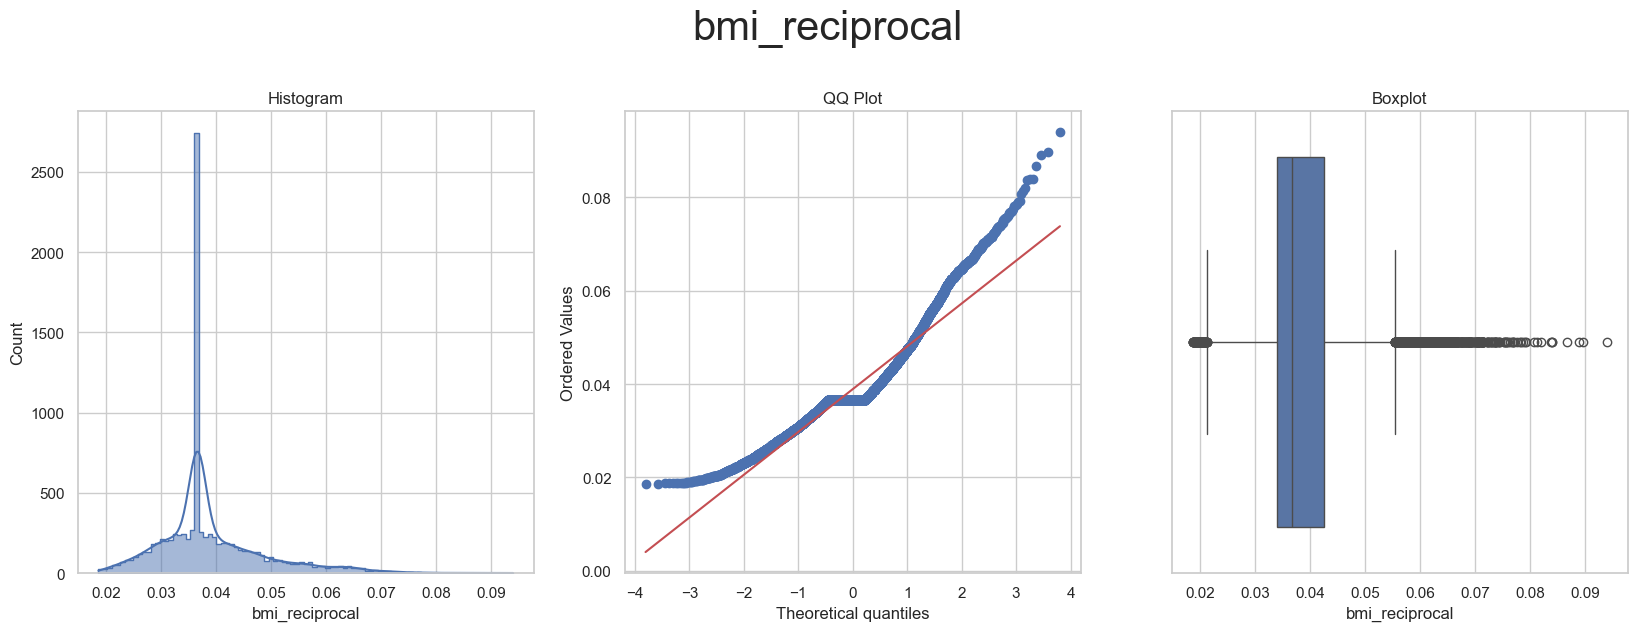

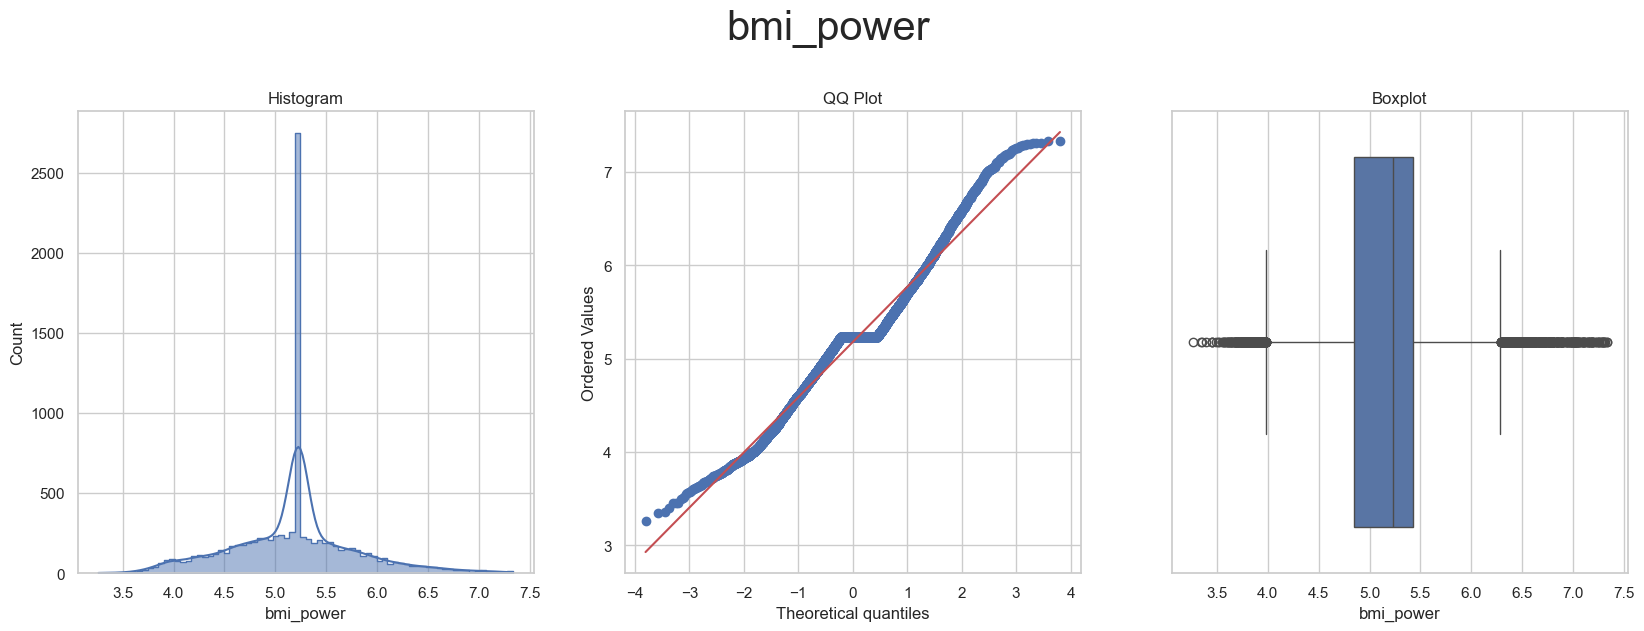

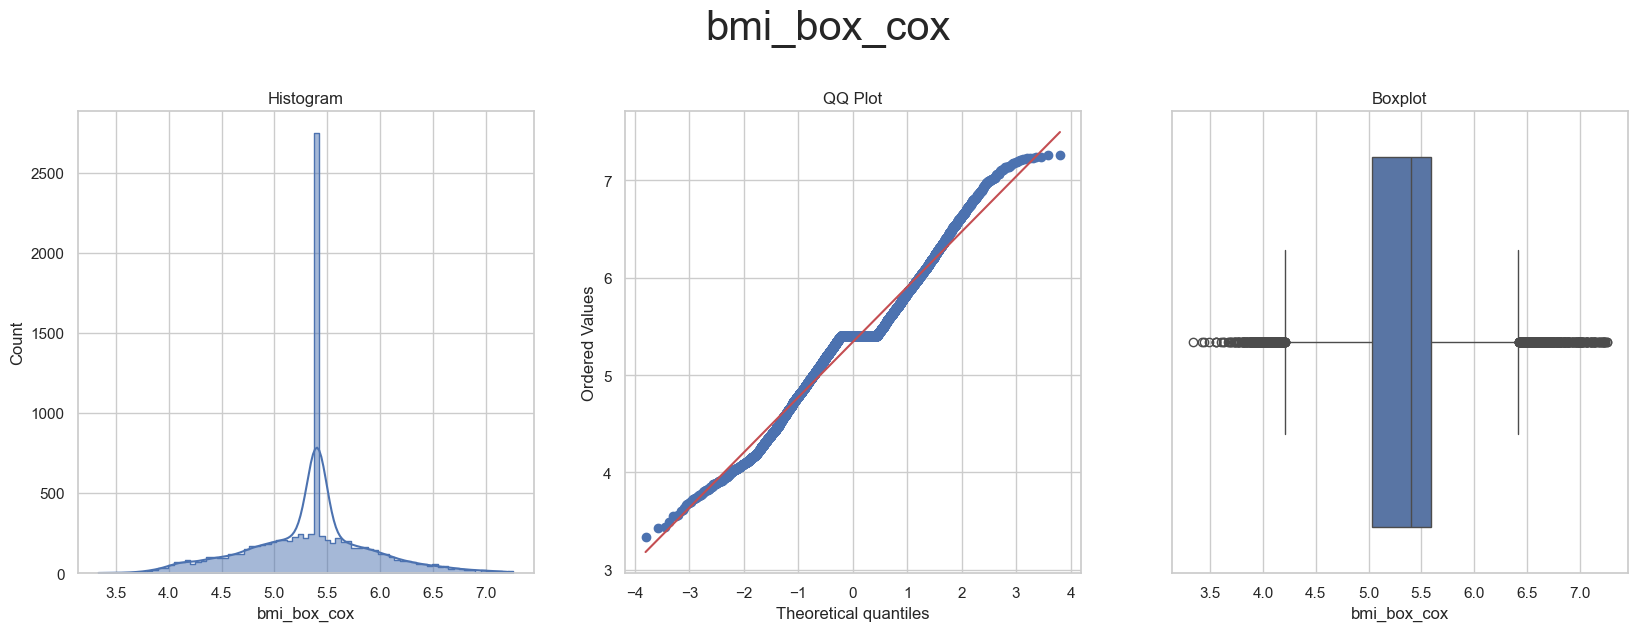

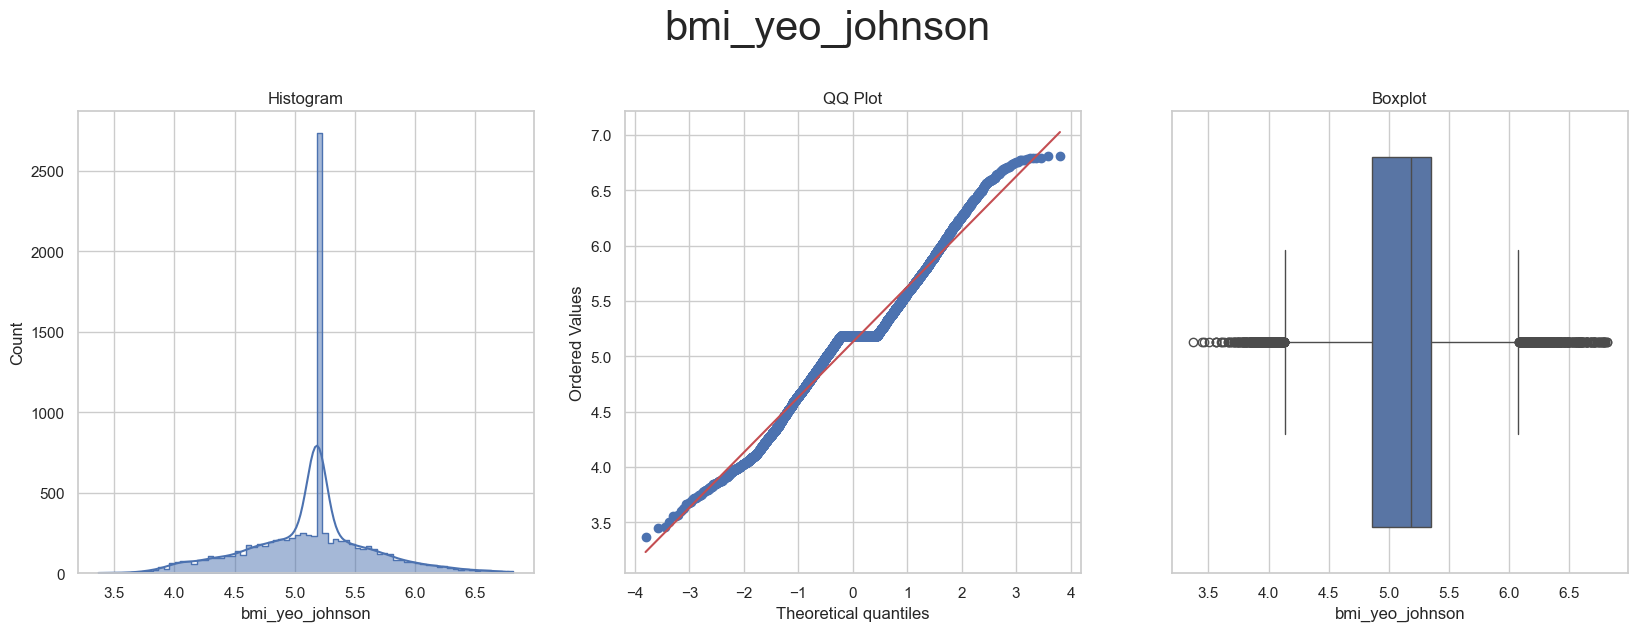

In [76]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering,analysis_type='numerical')